In [1]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import numpy as np
import healpy as hp
from astropy.io import fits
from pprint import pprint
from tqdm import tqdm
import pickle
import corner
import os

from scipy import optimize
from scipy.stats import poisson

import jax
import jax.numpy as jnp

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../utils/matplotlibrc')

from utils import ed_fcts_amarel as ef


/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load SVI fit results (these should be the only parameters that you are loading)
gpu_id = '3'

# name of the synthetic directory
sim_name = 'canon_g1p2_ola_v2'

# load SVI fit results (these should be the only parameters that you are loading)
sim_id = 7.1234567
temp_id = 5.23457
gp_id = 1.16
blg_id = -1
mod_id = 11
svi_id = 292
sim_seed = 1000
svi_seed = 0

In [3]:
# load GPU
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_id

data_dir = ef.load_data_dir(sim_name)
os.system("mkdir -p "+data_dir)

# Load the simulated templates
ebin = 10
temp_dict = np.load(data_dir + 'all_templates_ebin' + str(ebin)  + '.npy', allow_pickle=True).item()

In [4]:
fit_filename, module_name = ef.generate_fit_filename_from_ids(sim_id, temp_id, gp_id, blg_id, mod_id, svi_id, sim_seed, svi_seed)
fit_dir = data_dir + 'fits/' + fit_filename + '/'
ef.list_files(fit_dir)

sys.path.append(fit_dir)
import importlib 
module = importlib.import_module(module_name)

# Load all the variables from the module
globals().update(vars(module))

/
    ebin10_smp_svi_0.1_20000_mvn_8_1000_0.p
    ebin10_smp_svi_0.1_20000_mvn_8_1000_1.p
    ebin10_smp_svi_0.1_20000_mvn_8_1000_3.p
    ebin_old_10_smp_svi_0.1_20000_mvn_8_1000_4.p
    __init__.py
    settings_7p1234567_5p23457_1p16_-1_11_292_1000_0.py
    ebin10_smp_svi_0.1_20000_mvn_8_1000_2.p
    summary.txt
    ebin_old_10_smp_svi_0.1_20000_mvn_8_1000_1.p
    ebin_old_10_smp_svi_0.1_20000_mvn_8_1000_0.p
    ebin_old_10_smp_svi_0.1_20000_mvn_8_1000_2.p
    ebin_old_10_smp_svi_0.1_20000_mvn_8_1000_3.p
    ebin10_smp_svi_0.1_20000_mvn_8_1000_4.p


In [5]:
from models.poissonian_gp_roiscan import EbinPoissonModel

ebinmodel = EbinPoissonModel(
        # important parameters
        rig_temp_list = rig_temp_list,
        hyb_temp_list = hyb_temp_list,
        var_temp_list = var_temp_list,
        is_gp = is_gp,
        gp_deriv = gp_deriv,
        data_file = data_file,
        rig_temp_sim = rig_temp_sim,
        hyb_temp_sim = hyb_temp_sim,
        var_temp_sim = var_temp_sim,
        is_custom_blg = is_custom_blg,
        custom_blg_id = custom_blg_id,
        sim_seed = sim_seed,
        Nu = Nu,
        u_option = u_option,
        u_grid_type = u_grid_type,
        u_weights = u_weights,
        Np = Np,
        p_option = p_option,
        Nsub = Nsub,

        # default parameters
        ebin = ebin,
        is_float64 = is_float64,
        debug_nans = debug_nans,
        no_ps_mask = no_ps_mask,
        p_grid_type = p_grid_type,
        p_weights = p_weights,
        gp_kernel = gp_kernel,
        gp_params = gp_params,
        gp_scale_option = gp_scale_option,
        monotonicity_hyperparameter = monotonicity_hyperparameter,
        nfw_gamma = nfw_gamma,
        blg_names = blg_names,
        dif_names = dif_names,
        )
ebinmodel.config_model(ebin=ebin)
mask_p = ebinmodel.mask_roi_arr[ebin]

In [6]:
str_svi_seed = str(3)

# load saved data from GP -> Data fit
gp_file_name = ('ebin_old_' + str_ebin + '_smp_svi_' + 
             str_lr + '_' + str_n_steps + '_' + 
                str_guide + '_' + str_num_particles + '_' + 
                str_sim_seed + '_' + str_svi_seed + '.p')

if is_gp:
   samples, svi_results, gp_samples = pickle.load(open(fit_dir + gp_file_name, 'rb'))
else:
   samples, svi_results = pickle.load(open(fit_dir + gp_file_name, 'rb'))

In [7]:
ebin = 10
temp_dict = np.load(data_dir + 'all_templates_ebin' + str(ebin)  + '.npy', allow_pickle=True).item()

true_params = {}
true_params['S_nfw'] = temp_dict['S_nfw']
true_params['S_iso'] = temp_dict['S_iso']
true_params['S_blg'] = temp_dict['S_blg']
true_params['S_psc'] = temp_dict['S_psc']
true_params['S_bub'] = temp_dict['S_bub']
true_params['S_pib'] = temp_dict['S_pib']
true_params['S_ics'] = temp_dict['S_ics']
true_params['gamma'] = temp_dict['gamma']

In [8]:
# # generate samples and plot histograms of log counts

# temp_names_sim = rig_temp_sim + hyb_temp_sim + var_temp_sim # imported from settings file
# temp_sample_dict = ef.generate_temp_sample_maps(samples, ebinmodel, gp_samples = gp_samples)
# ef.tot_log_counts_hist(temp_sample_dict, temp_dict, temp_names_sim, bins = np.linspace(1.6,5.,200), gp_model_nfw=True, gp_model_iso = False)

In [9]:
outer_radius_list = [20.25, 22.5, 25., 27.5, 30.] 

svi_results_list = []
samples_list = []
gp_samples_list = []
temp_sample_dict_list = []

for svi_seed in tqdm(range(len(outer_radius_list))):
   str_svi_seed = str(svi_seed)
   # load saved data from GP -> Data fit
   gp_file_name = ('ebin_old_' + str_ebin + '_smp_svi_' + 
               str_lr + '_' + str_n_steps + '_' + 
                  str_guide + '_' + str_num_particles + '_' + 
                  str_sim_seed + '_' + str_svi_seed + '.p')

   if is_gp:
      samples, svi_results, gp_samples = pickle.load(open(fit_dir + gp_file_name, 'rb'))
   else:
      samples, svi_results = pickle.load(open(fit_dir + gp_file_name, 'rb'))
   temp_sample_dict = ef.generate_temp_sample_maps(samples, ebinmodel, gp_samples = gp_samples, custom_mask = mask_p, custom_num=1000, nfw_gamma=nfw_gamma)

   svi_results_list.append(svi_results)
   samples_list.append(samples)
   gp_samples_list.append(gp_samples)
   temp_sample_dict_list.append(temp_sample_dict)

print('Done!')

  0%|          | 0/5 [00:00<?, ?it/s]

iso
psc
bub
pib


100%|██████████| 1000/1000 [00:05<00:00, 189.14it/s]


ics


 20%|██        | 1/5 [00:11<00:45, 11.44s/it]

iso
psc
bub
pib


100%|██████████| 1000/1000 [00:05<00:00, 195.43it/s]


ics


 40%|████      | 2/5 [00:24<00:36, 12.13s/it]

iso
psc
bub
pib


100%|██████████| 1000/1000 [00:05<00:00, 192.44it/s]


ics


 60%|██████    | 3/5 [00:34<00:22, 11.46s/it]

iso
psc
bub
pib


100%|██████████| 1000/1000 [00:05<00:00, 185.00it/s]


ics


 80%|████████  | 4/5 [00:46<00:11, 11.50s/it]

iso
psc
bub
pib


100%|██████████| 1000/1000 [00:05<00:00, 195.35it/s]


ics


100%|██████████| 5/5 [00:57<00:00, 11.48s/it]

Done!


In [10]:
norm_sum_list = []
for n in tqdm(range(len(outer_radius_list))):
    temp_sample_dict = temp_sample_dict_list[n]

    norm_sum = {}
    for name in list(temp_sample_dict.keys()):
        if name == 'gp':
            true_sum = temp_dict['nfw'][~mask_p].sum() + temp_dict['blg'][~mask_p].sum()
            norm_sum[name] = (temp_sample_dict[name].sum(axis=1) - true_sum) / true_sum
        else:
            true_sum = temp_dict[name][~mask_p].sum()
            norm_sum[name] = (temp_sample_dict[name].sum(axis=1) - true_sum) / true_sum

    norm_sum_list.append(norm_sum)

q_dict = {}
for name in list(norm_sum.keys()):
    q_dict[name] = np.quantile(np.array([norm_sum[name] for norm_sum in norm_sum_list]), [0.16, 0.5, 0.84], axis=1) 

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00,  9.28it/s]


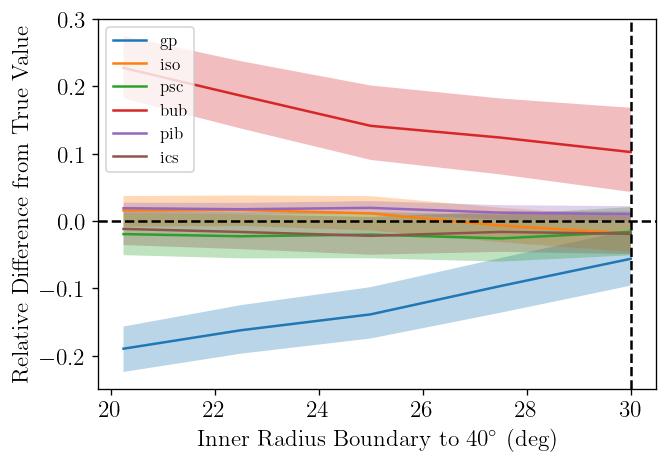

In [11]:
for name in list(norm_sum.keys()):
    plt.plot(outer_radius_list, q_dict[name][1], label=name)
    plt.fill_between(outer_radius_list, q_dict[name][0], q_dict[name][2], alpha=0.3)
plt.legend(fontsize = 10)
plt.xlabel('Inner Radius Boundary to $40^{\circ}$ (deg)')
plt.ylabel('Relative Difference from True Value')
plt.axvline(x = 30, color = 'black', linestyle = '--')
plt.axhline(y = 0, color = 'black', linestyle = '--')

In [12]:
pickle.dump(
    (outer_radius_list, q_dict),
    open('../figures/data/appdata_roi_inner_radius_scan_upto40.p', 'wb')
)

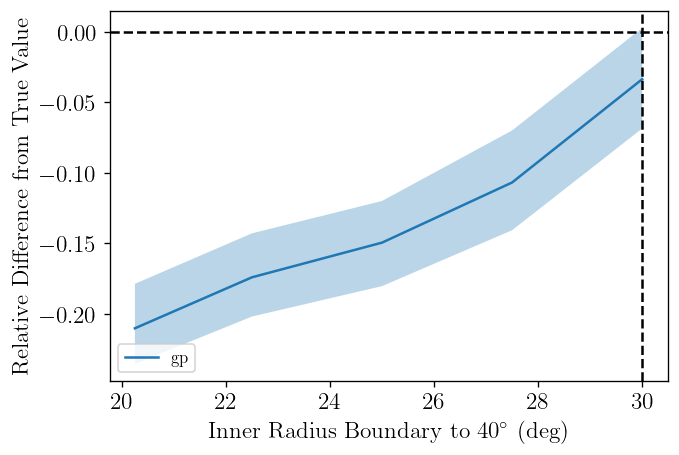

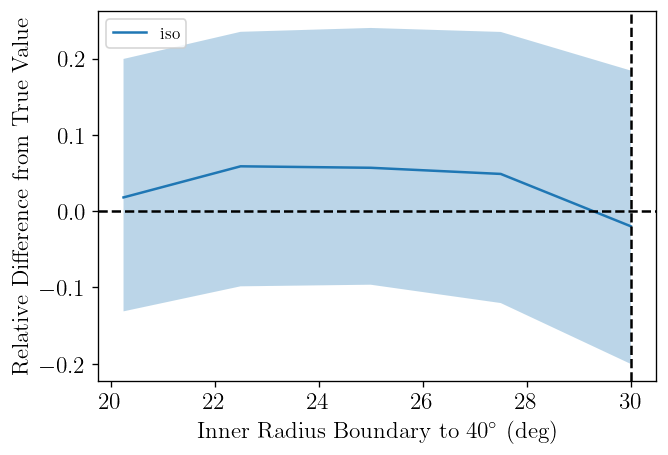

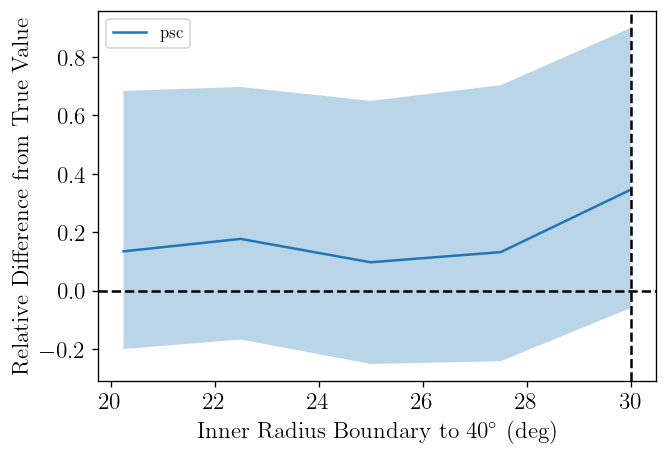

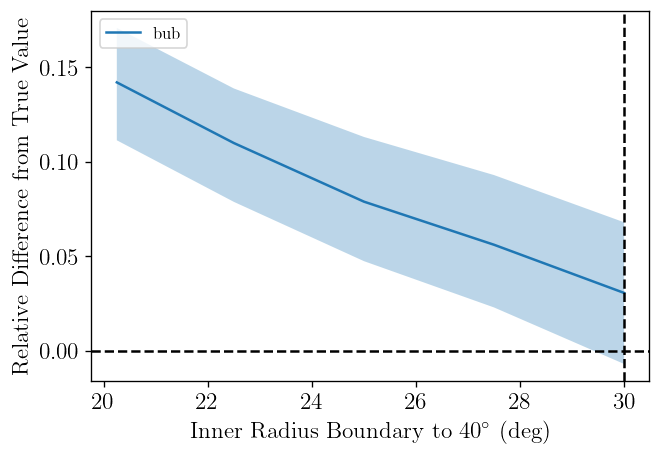

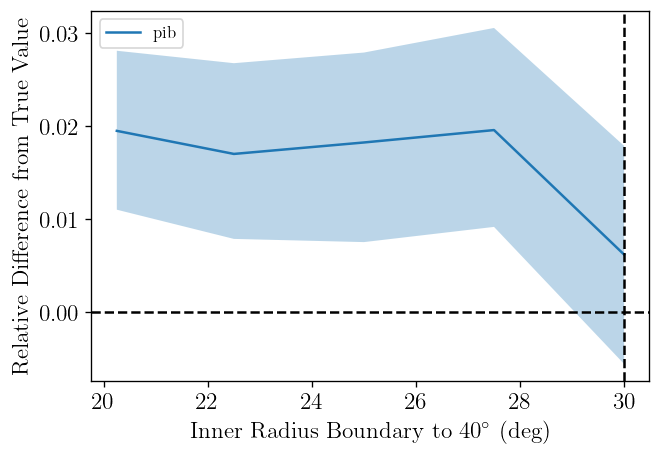

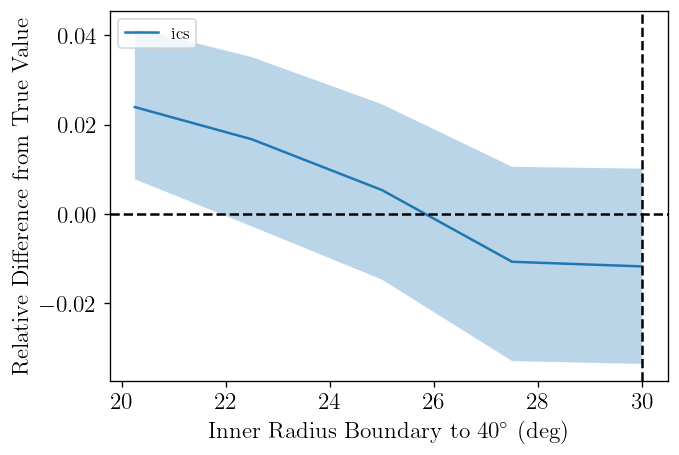

In [14]:
# plot each separately
for name in list(norm_sum.keys()):
    plt.figure()
    plt.plot(outer_radius_list, q_dict[name][1], label=name)
    plt.fill_between(outer_radius_list, q_dict[name][0], q_dict[name][2], alpha=0.3)
    plt.legend(fontsize = 10)
    plt.xlabel('Inner Radius Boundary to $40^{\circ}$ (deg)')
    plt.ylabel('Relative Difference from True Value')
    plt.axvline(x = 30, color = 'black', linestyle = '--')
    plt.axhline(y = 0, color = 'black', linestyle = '--')

In [6]:
# define custom optimizer (can be None if want to use default)
import optax
import numpyro
from numpyro import optim

schedule = optax.warmup_exponential_decay_schedule(
    init_value=0.005,
    peak_value=0.05,
    warmup_steps=1000,
    transition_steps=3000,
    decay_rate=1./jnp.exp(1.),
    transition_begin=2000,
)
optimizer = optim.optax_to_numpyro(
    optax.chain(
        optax.clip(1.),
        optax.adam(learning_rate=schedule), 
    )
)

In [7]:
from numpyro.infer.initialization import init_to_sample
from utils import create_mask as cm

# configure model, run SVI, and generate samp 
rng_key = jax.random.PRNGKey(svi_seed)

In [8]:
# outer_radius_list = [None, 32.5, 35., 40., 45., 50., 60., 70.]
outer_radius_list = [50., 60., 70.]

svi_results_list = []
samples_list = []
gp_samples_list = []
temp_sample_dict_list = []

for outer_radius in tqdm(outer_radius_list):
    print(outer_radius)
    if outer_radius == None:
        ebinmodel.outer_mask = None
    else:
        ebinmodel.outer_mask = np.asarray([
            cm.make_mask_total(
                nside=ebinmodel.nside,
                band_mask=True,
                band_mask_range=ebinmodel.mask_roi_b,
                mask_ring=True,
                inner=30.,
                outer=outer_radius,
                custom_mask=mask_ps_at_eng
            )
            for mask_ps_at_eng in ebinmodel.mask_ps_arr
        ])

    rng_key, key = jax.random.split(rng_key)
    ebinmodel.config_model(ebin=ebin)
    svi_results = ebinmodel.cfit_SVI(
        rng_key=key,
        guide=guide, 
        n_steps=n_steps, 
        lr=lr, 
        num_particles=num_particles,
        ebin=ebin, optimizer = optimizer,
        init_loc_fn = init_to_sample,
    )
    rng_key, key = jax.random.split(rng_key) 
    samples = ebinmodel.cget_svi_samples(rng_key = key, num_samples=1000)

    if is_gp:
        if u_option == 'None':
            gp_samples = samples['log_rate']
        else:
            # gp_samples = ebinmodel.get_gp_samples(num_samples=1000) # v1 (sequential)
            # gp_samples = ebinmodel.cget_gp_samples(svi_results, samples, num_samples=1000, min_loss = False) #v2 (sequential)
            ebinmodel.predictive(ebinmodel.guide, num_samples = 1, params = svi_results.params)
            rng_key, key = jax.random.split(rng_key)
            gp_samples = ebinmodel.cget_gp_samples_vec(key, 1000, svi_results) #v3 (vectorized)
    else:
        print('No GP Model, No GP Samples')
        
    # make template dictionaries
    temp_names_sim = rig_temp_sim + hyb_temp_sim + var_temp_sim # imported from settings file
    temp_sample_dict = ef.generate_temp_sample_maps(samples, ebinmodel, gp_samples = gp_samples)

    # make list of fit results
    # svi_results_list.append(svi_results)
    # samples_list.append(samples)
    # gp_samples_list.append(gp_samples)
    # temp_sample_dict_list.append(temp_sample_dict)

    # save svi results and samples to file
    file_name = ('ebin' + str_ebin + '_smp_svi_' + 
                str_lr + '_' + str_n_steps + '_' + 
                    str_guide + '_' + str_num_particles + '_' + 
                    str_sim_seed + '_' + str_svi_seed + '.p')
    if is_gp:
        pickle.dump(
            (samples, svi_results, gp_samples), 
            open(fit_dir + file_name, 'wb'))
    else:
        pickle.dump(
            (samples, svi_results), 
            open(fit_dir + file_name, 'wb'))

    # update svi_seed for naming
    svi_seed += 1
    str_svi_seed = str(svi_seed)

  0%|          | 0/3 [00:00<?, ?it/s]

50.0


In [ ]:
# print file contents in fit_dir
print(fit_dir)
print(os.listdir(fit_dir))

/data/edr76/gce-prob-prog-ed-v0.3/data/synthetic_data/canon_g1_ola/fits/fit_7p1234567_5p23457_1p16_-1_20_0/seed_1003_0/
['ebin10_smp_svi_0.1_15000_mvn_8_1003_4.p', 'ebin10_smp_svi_0.1_500_mvn_8_1003_0.p', 'ebin10_smp_svi_0.1_15000_mvn_8_1003_1.p', 'ebin10_smp_svi_0.1_15000_mvn_8_1003_0.p', 'ebin10_smp_svi_0.1_15000_mvn_8_1003_2.p', 'summary.txt', 'ebin10_smp_svi_0.1_15000_mvn_8_1003_3.p', 'settings_7p1234567_5p23457_1p16_-1_20_0_1003_0.py', '__init__.py']
